In [1]:
import numpy as np
import pandas as pd
from scipy.stats import beta
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

In [2]:
from util_func import RunModel, calculate_expected_loss, visualize_joint_posterior, visualize_loss,calc_stats_between_buckets_for_column

## Compare prior distributions

In [3]:
# Input: alpha and beta as shape parameters
# conversion rate prior: uniform, 1%, 3%, 5%, 7%, 9%
priors = [(1,1), (2,100), (4, 98), (6,96), (8,94), (10, 92)]
_alpha, _beta = zip(*priors)

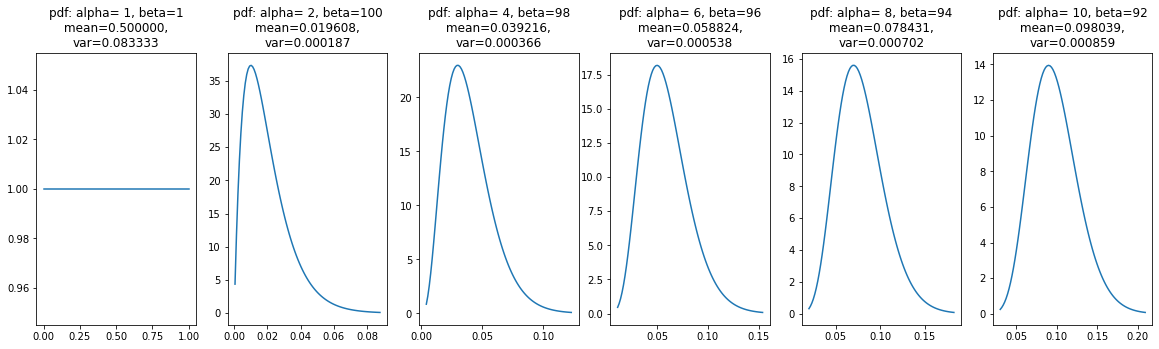

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,5))
for i in range(6):
    a, b = _alpha[i], _beta[i]
    mean, var = beta.stats(a, b)
    x = np.linspace(beta.ppf(0.001, a, b),
              beta.ppf(0.999,a,b), 100)
    ax = axes[i]
    ax.plot(x, beta.pdf(x, a, b))
    ax.title.set_text('pdf: alpha= %i, beta=%i\n mean=%f, \nvar=%f'%(a,b, mean, var))

## How does priors affect experiment runtime and results?

### Load model

In [5]:
conversion_model = """
data {
  int<lower=0> observations;            
  int<lower=0> observation_conversion_count;
  real<lower=0> prior_alpha;
  real<lower=0> prior_beta;
}

parameters {
  real<lower=0, upper=0.8> theta;
}

model {
  theta ~ beta(prior_alpha, prior_beta);
  observation_conversion_count ~ binomial(observations, theta);
}

"""
sm_conversion = pystan.StanModel(model_code = conversion_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_97f75449d47461cb90cfbe6583c57f7b NOW.


### Generate simulations

In [6]:
# Generate simulation data
n_per_day = 1000
p1 = 0.069
p2 = 0.063
date_range = pd.date_range(start = '2020-01-01', periods = 30)
df1 = pd.DataFrame()
df2 = pd.DataFrame()
for t in date_range:
    y1 = np.random.binomial(n=1, p=p1, size=n_per_day)
    y2 = np.random.binomial(n=1, p=p2, size=n_per_day) 
    dfy1 = pd.DataFrame(y1, columns=['is_converted'])
    dfy2 = pd.DataFrame(y2, columns=['is_converted'])
    dfy1['participation_timestamp_rounded_up'] = t
    dfy2['participation_timestamp_rounded_up'] = t
    df1 = pd.concat([df1, dfy1], axis =0)
    df2 = pd.concat([df2, dfy2], axis =0)
    
df1['bucket'] = 'bucket1'
df2['bucket'] = 'bucket2'
df = pd.concat([df1, df2], axis = 0)

### Run model on different priors

In [7]:
metric = 'conversion'
stan_model = sm_conversion

#### Uniform priors

0.07
0.065
loss if choosing variant1: 0.002484495726002523
loss if choosing variant2: 0.007394971773393347
Bucket 1 quartiles: [0.05807013 0.0650705  0.07038117 0.07634884 0.084913  ]
Bucket 2 quartiles: [0.05397316 0.06042222 0.06556592 0.07089355 0.07974291]


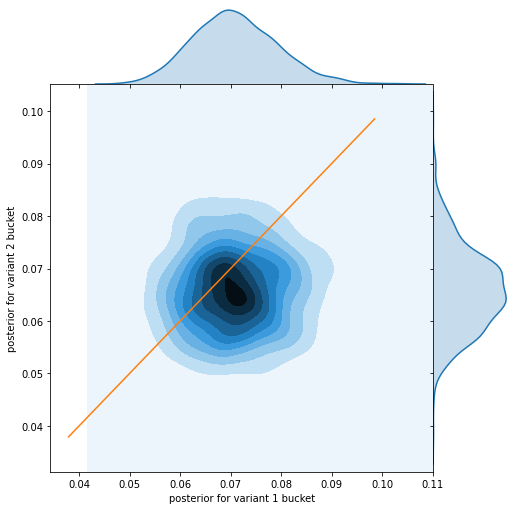

In [8]:
stats = []
num_days = 0
max_days = 5
err_thres = 0.0005

i=0
a, b = _alpha[i], _beta[i]

ts=date_range[1]
closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

0.0685
0.06
loss if choosing variant1: 0.00047755322983306114
loss if choosing variant2: 0.00908612648948457
Bucket 1 quartiles: [0.0599037  0.06504843 0.06885682 0.07252642 0.07854358]
Bucket 2 quartiles: [0.05188777 0.05664524 0.0602422  0.06381636 0.06929143]
It takes 2 day(s) to draw the conclusion


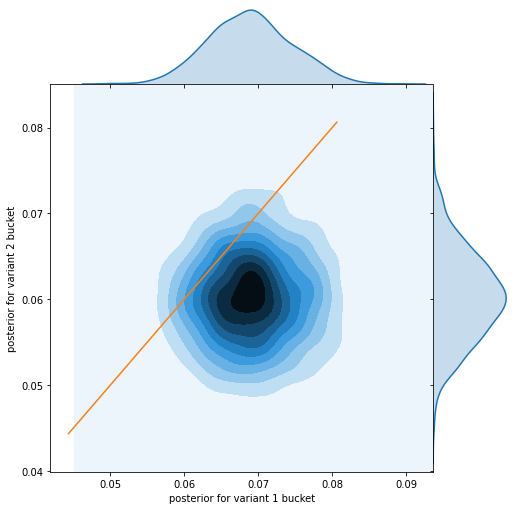

In [9]:
num_days=2
ts=date_range[num_days]
closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

In this simulation, when we use uniform priors, it takes 2 days to make (the right) conclusion.

In [ ]:
num_days=3
ts=date_range[num_days]
closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

#### Alpha = 2, beta =100, mean_cvr =1%

0.07
0.065
loss if choosing variant1: 0.0022870280235159227
loss if choosing variant2: 0.0065701628519484
Bucket 1 quartiles: [0.05391802 0.06017866 0.06523968 0.07036597 0.07866315]
Bucket 2 quartiles: [0.05040426 0.05652265 0.06101453 0.06563009 0.07282892]


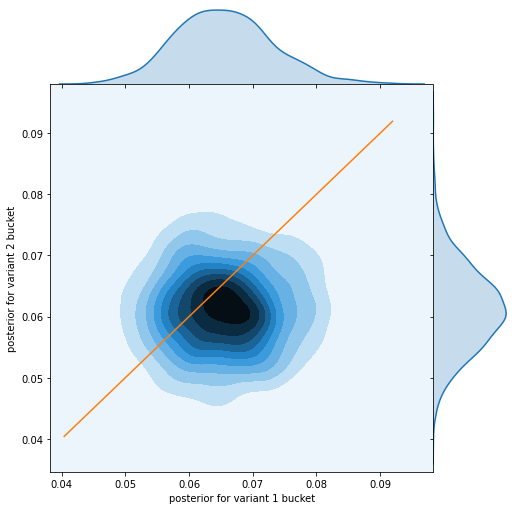

In [10]:
# Alpha = 2, beta =100, cvr =1%
stats = []
err_thres = 0.0005

i=1
a, b = _alpha[i], _beta[i]

num_days=1
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

0.0685
0.06
loss if choosing variant1: 0.0005082821176137503
loss if choosing variant2: 0.00862251403452628
Bucket 1 quartiles: [0.05760098 0.06216207 0.06590353 0.0696129  0.07601826]
Bucket 2 quartiles: [0.05034347 0.05469316 0.05779167 0.06120598 0.06644175]


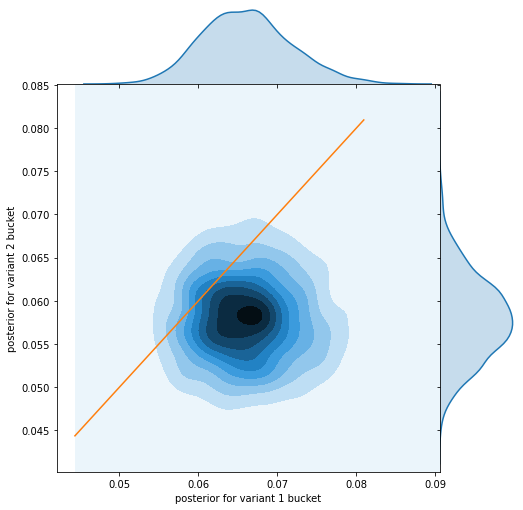

In [11]:
num_days=2
ts=date_range[num_days]
closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

0.07033333333333333
0.06266666666666666
loss if choosing variant1: 0.00029214157330554566
loss if choosing variant2: 0.007971334575790143
Bucket 1 quartiles: [0.06206564 0.06590826 0.0688071  0.07192951 0.07671703]
Bucket 2 quartiles: [0.05437599 0.05834834 0.06116092 0.06425033 0.06856633]
It takes 3 day(s) to draw the conclusion


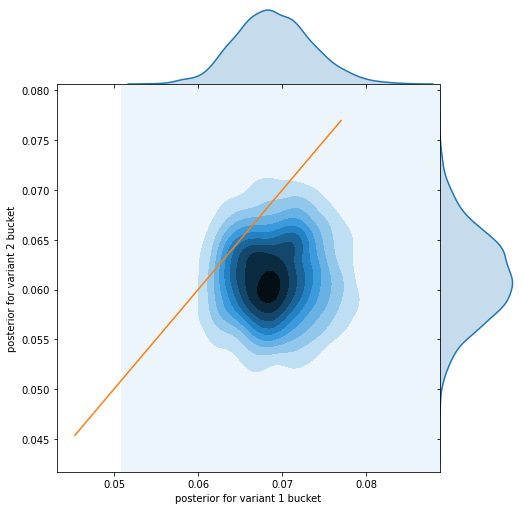

In [12]:
num_days=3
ts=date_range[num_days]
closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

#### Alpha = 4, beta =98, mean_cvr =3%

0.07
0.065
loss if choosing variant1: 0.002395384515391851
loss if choosing variant2: 0.0067713605533993365
Bucket 1 quartiles: [0.05452965 0.06161728 0.06684746 0.07184931 0.07898959]
Bucket 2 quartiles: [0.05130731 0.05755333 0.06209761 0.06696353 0.07520258]


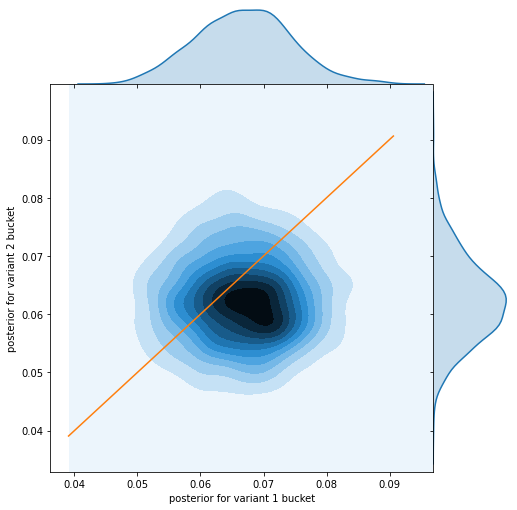

In [16]:
# Alpha = 4, beta =98, cvr =3%
stats = []
err_thres = 0.0005

i=2
a, b = _alpha[i], _beta[i]

num_days=1
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

0.0685
0.06
loss if choosing variant1: 0.00047114604083577197
loss if choosing variant2: 0.009147006486164901
Bucket 1 quartiles: [0.05826974 0.06322687 0.067086   0.07101386 0.07682665]
Bucket 2 quartiles: [0.04963323 0.0550681  0.05860751 0.0621346  0.06740376]
It takes 2 day(s) to draw the conclusion


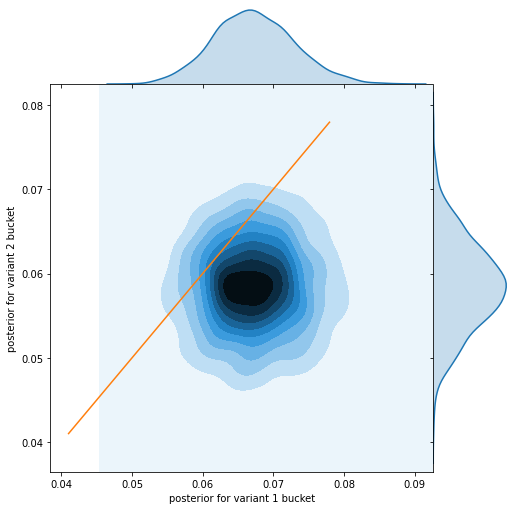

In [17]:
num_days=2
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

#### Alpha=6, Beta=96, mean_cvr= 5%

0.07
0.065
loss if choosing variant1: 0.002306429117089822
loss if choosing variant2: 0.006698817158286177
Bucket 1 quartiles: [0.05693533 0.06369718 0.06869014 0.07389024 0.08146025]
Bucket 2 quartiles: [0.05274931 0.05937425 0.06431987 0.06935693 0.07678975]


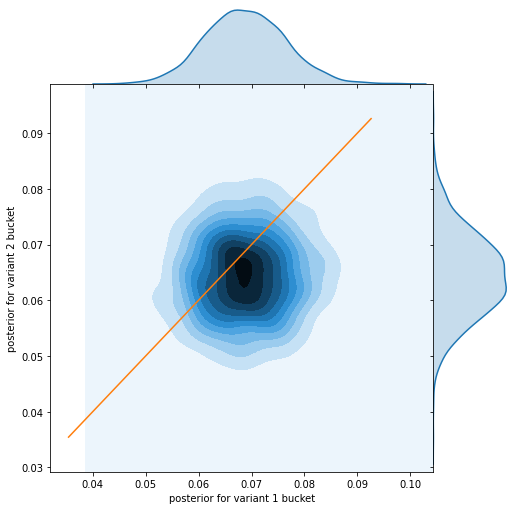

In [18]:
# Alpha = 6, beta =96, cvr =5%
stats = []
err_thres = 0.0005

i=3
a, b = _alpha[i], _beta[i]

num_days=1
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

0.0685
0.06
loss if choosing variant1: 0.0004655559353659514
loss if choosing variant2: 0.00869431438134513
Bucket 1 quartiles: [0.05992893 0.0646138  0.06818645 0.07183899 0.07699023]
Bucket 2 quartiles: [0.05182293 0.05644543 0.05990703 0.06380696 0.06870172]
It takes 2 day(s) to draw the conclusion


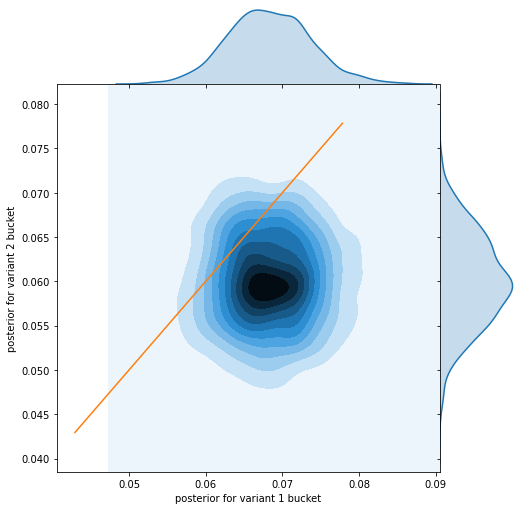

In [19]:
num_days=2
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

#### Alpha=8, Beta=94, mean_cvr= 7%

0.07
0.065
loss if choosing variant1: 0.002298566881179135
loss if choosing variant2: 0.006956745710267238
Bucket 1 quartiles: [0.05883643 0.06571236 0.07063167 0.07587193 0.08483615]
Bucket 2 quartiles: [0.05454009 0.06108154 0.06604477 0.07115162 0.07897393]


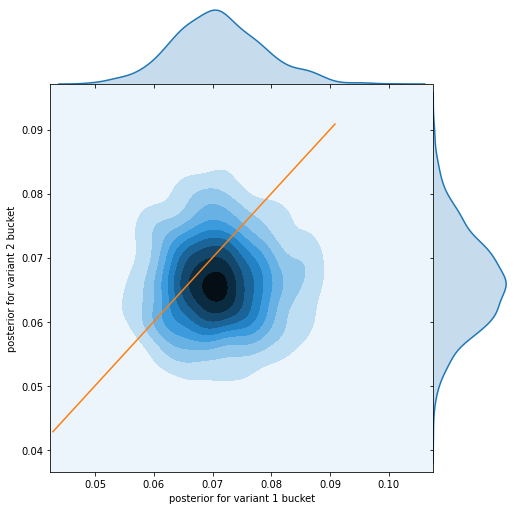

In [20]:
# Alpha = 8, beta =94, cvr =7%
stats = []
err_thres = 0.0005

i=4
a, b = _alpha[i], _beta[i]

num_days=1
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

0.0685
0.06
loss if choosing variant1: 0.0005573711612170786
loss if choosing variant2: 0.008503467982540109
Bucket 1 quartiles: [0.0603503  0.0650809  0.06877004 0.07266569 0.07809207]
Bucket 2 quartiles: [0.05234908 0.05743467 0.06090873 0.06460552 0.06971779]


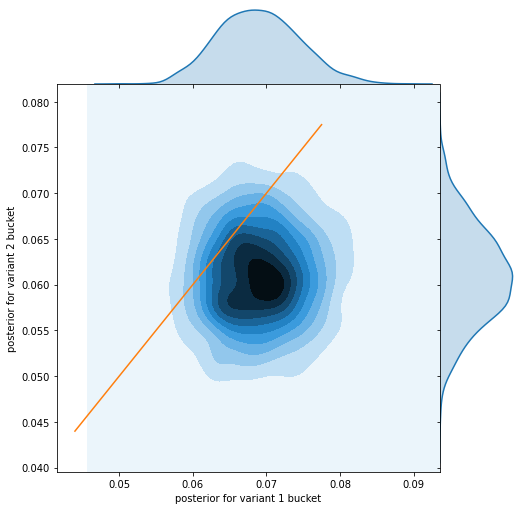

In [21]:
num_days=2
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

0.07033333333333333
0.06266666666666666
loss if choosing variant1: 0.00039945800063908644
loss if choosing variant2: 0.007774871297906612
Bucket 1 quartiles: [0.06332014 0.06733999 0.07035901 0.07359161 0.07805076]
Bucket 2 quartiles: [0.05615547 0.05998177 0.06307015 0.06598668 0.07051516]
It takes 3 day(s) to draw the conclusion


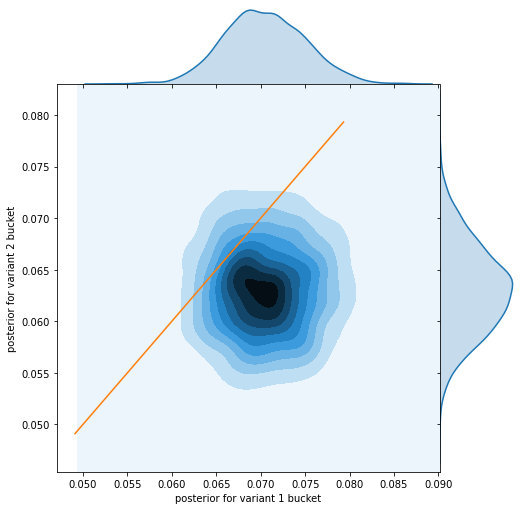

In [22]:
num_days=3
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

In [ ]:
#### Alpha=8, Beta=94, mean_cvr= 7%

0.07
0.065
loss if choosing variant1: 0.002315981041673268
loss if choosing variant2: 0.007188942330591832
Bucket 1 quartiles: [0.0600516  0.06759311 0.07255257 0.07774685 0.08622013]
Bucket 2 quartiles: [0.05549911 0.06267216 0.06791984 0.07307812 0.0802956 ]


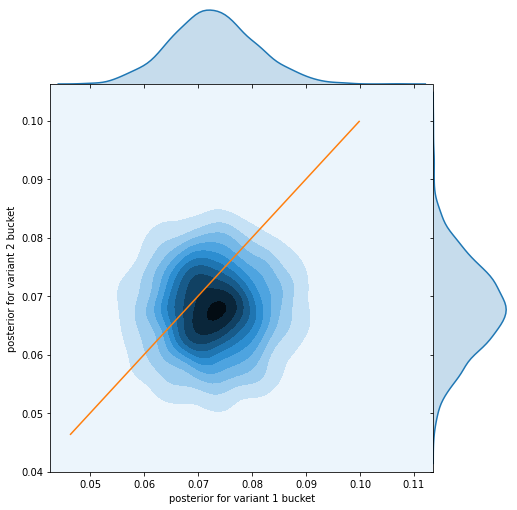

In [23]:
# Alpha = 10, beta =92, cvr =9%
stats = []
err_thres = 0.0005

i=5
a, b = _alpha[i], _beta[i]

num_days=1
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

0.0685
0.06
loss if choosing variant1: 0.0005560621397064129
loss if choosing variant2: 0.008802321078082109
Bucket 1 quartiles: [0.06104408 0.06585905 0.06965629 0.07357456 0.07907433]
Bucket 2 quartiles: [0.05361245 0.05809624 0.06146945 0.06496752 0.06981153]


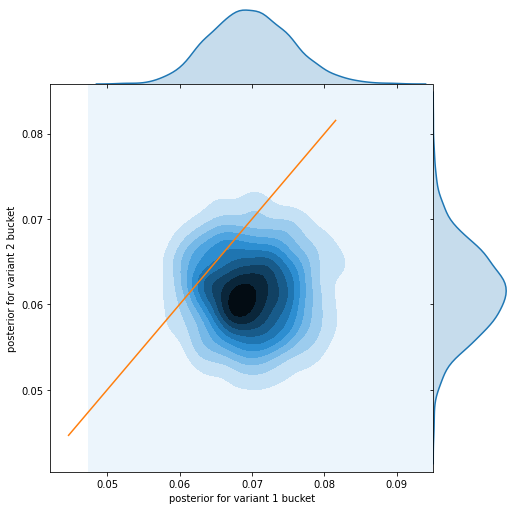

In [24]:
num_days=2
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

0.07033333333333333
0.06266666666666666
loss if choosing variant1: 0.00044809063130087426
loss if choosing variant2: 0.007829934167150675
Bucket 1 quartiles: [0.0640378  0.0683798  0.07141023 0.0746298  0.07907668]
Bucket 2 quartiles: [0.05693708 0.06105596 0.06400955 0.06710179 0.07181023]
It takes 3 day(s) to draw the conclusion


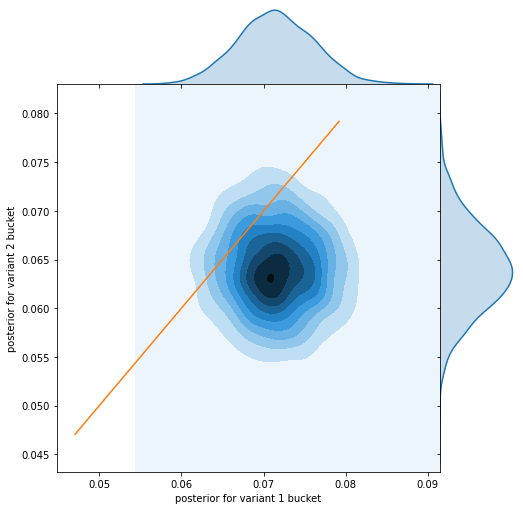

In [25]:
num_days=3
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')